In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import arviz as az
from cycler import cycler

from sphincter.data_preparation import load_prepared_data
from sphincter.plotting import plot_obs, plot_predictive, save_figure


CMAP = plt.get_cmap('Set2')

plt.rcParams['axes.prop_cycle'] = cycler(color=CMAP.colors)

In [2]:
raw = pd.read_csv("../data/raw/hyper_challenge.csv")
prepped = load_prepared_data("../data/prepared/hypertension.json")

/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.13/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [3]:
msts = prepped.measurements
msts.head()

,age,treatment,mouse,vessel_type,corr_bp_diam,atanh_corr_bp_diam
168,adult,hyper1,11020,bulb,0.900308,1.473841
152,adult,hyper1,110321,bulb,-0.336590,-0.350242
192,adult,hyper1,121020,bulb,0.244380,0.249427
194,adult,hyper1,140920,bulb,0.372125,0.390887
148,adult,hyper1,160321,bulb,0.833789,1.200440


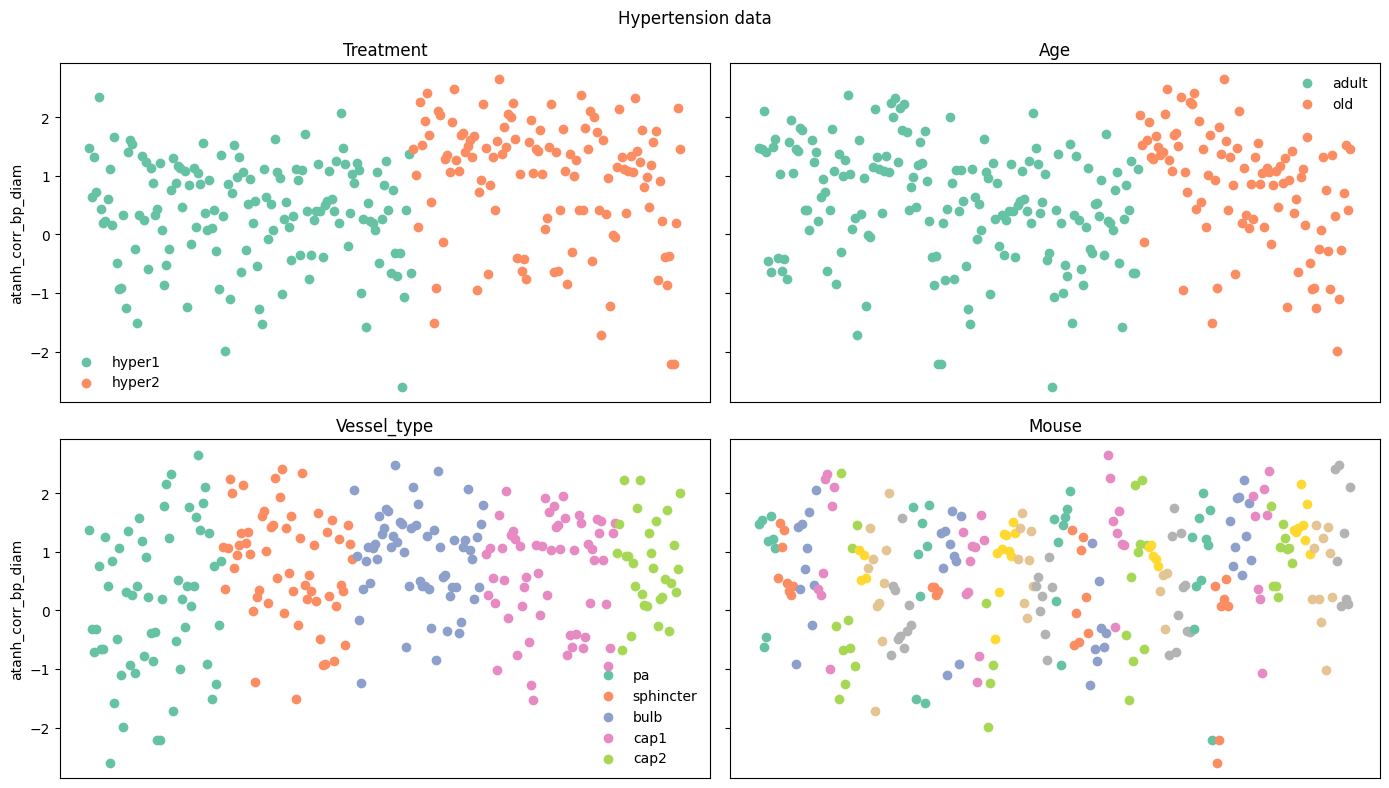

In [4]:
ycol = "atanh_corr_bp_diam"

f, axes = plt.subplots(2, 2, figsize=[14, 8], sharey=True)
axes = axes.ravel()
for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
    sct = plot_obs(ax, msts[ycol], cat=msts[col])
    if col != "mouse":
        ax.legend(frameon=False);
    if i % 2 == 0:
        ax.set_ylabel(ycol);
    ax.set_xticks([])
    ax.set_title(col.capitalize())
f.suptitle("Hypertension data");
f.tight_layout()
save_figure(f, "hypertension-data")

In [5]:
idatas = {
    dirname: az.InferenceData.from_zarr(os.path.join("..", "inferences", dirname, "idata"))
    for dirname in ["hypertension-big", "hypertension-basic"]
}
for idata_name, idata in idatas.items():
    print(idata_name + ":")
    display(az.summary(idata.sample_stats))

hypertension-big:


/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acceptance_rate,0.991,0.013,0.968,1.000,0.002,0.001,74.0,294.0,1.06
diverging,0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
energy,-46.253,5.413,-55.873,-35.536,0.159,0.113,1161.0,2024.0,1.00
lp,59.235,4.093,51.767,66.930,0.118,0.083,1226.0,2234.0,1.00
n_steps,177.312,65.239,127.000,255.000,25.415,18.833,7.0,6.0,1.58
step_size,0.026,0.006,0.020,0.035,0.003,0.002,4.0,4.0,inf
tree_depth,7.276,0.511,7.000,8.000,0.179,0.132,9.0,8.0,1.40


hypertension-basic:


/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acceptance_rate,0.986,0.019,0.955,1.000,0.000,0.000,4400.0,3968.0,1.01
diverging,0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
energy,-58.707,4.458,-66.866,-50.324,0.140,0.099,1052.0,1950.0,1.00
lp,67.229,3.328,60.740,72.905,0.108,0.077,990.0,1435.0,1.00
n_steps,415.256,399.232,63.000,1023.000,7.100,5.021,2963.0,186.0,1.01
step_size,0.042,0.004,0.038,0.049,0.002,0.002,4.0,4.0,inf
tree_depth,7.691,1.568,6.000,10.000,0.028,0.020,2835.0,116.0,1.02


arviz - WARNING - Array contains NaN-value.


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hypertension-basic,0,-168.819740,11.095758,0.000000,1.0,11.576201,0.000000,False,log
hypertension-big,1,-169.421256,11.942179,0.601517,0.0,11.561163,0.299307,False,log


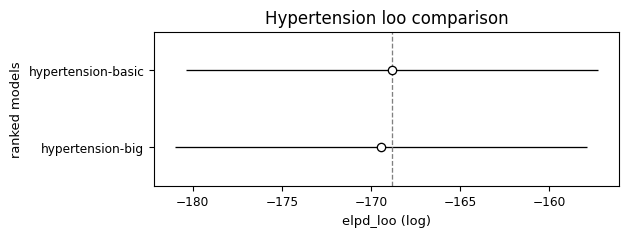

In [6]:
comp = az.compare(idatas)

display(comp)

f, ax = plt.subplots(figsize=[6, 2])
az.plot_compare(comp, ax=ax)
ax.set(title="Hypertension loo comparison")
save_figure(f, "hypertension-loo")

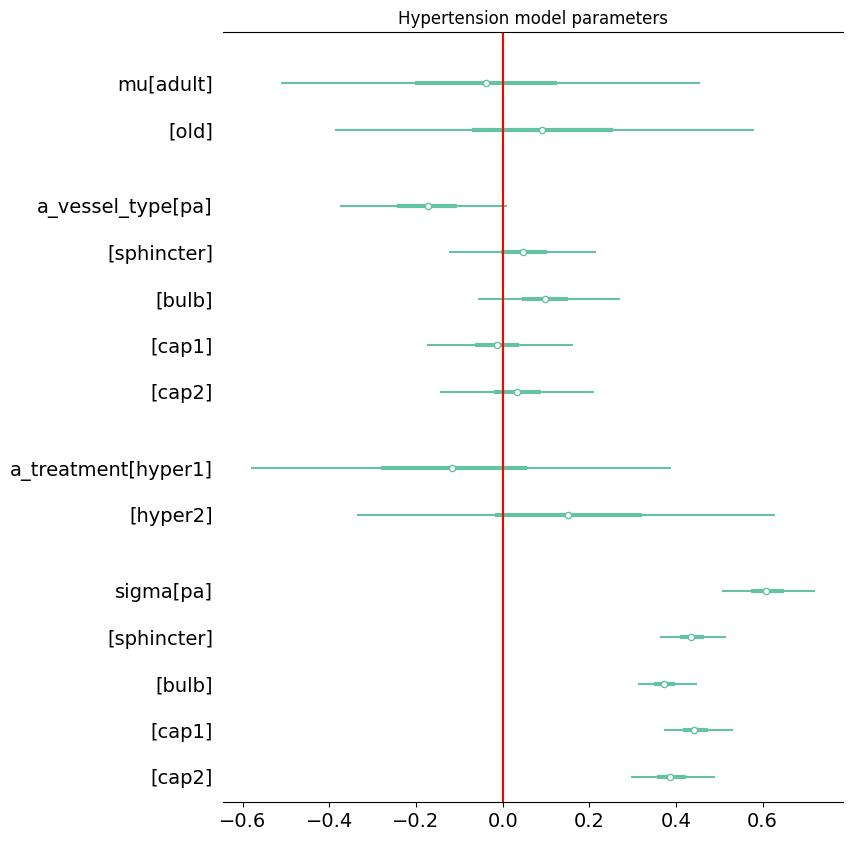

In [7]:
vars = ["mu", "a_vessel_type", "a_treatment", "sigma"]
f, ax = plt.subplots(figsize=[8, 10], sharex=True)
az.plot_forest(
    idatas["hypertension-basic"],
    ax=ax,
    combined=True,
    var_names=vars,
);
ax.set(title="Hypertension model parameters")
ax.axvline(0, color="red");

save_figure(f, "hypertension-parameters")

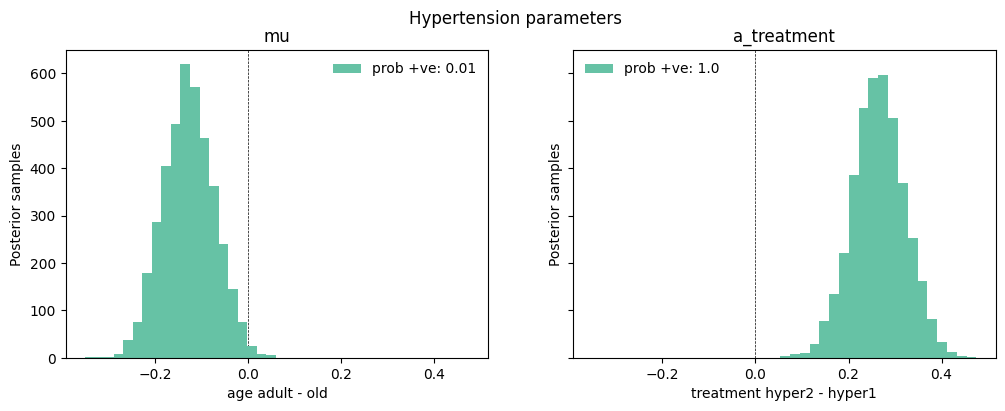

In [8]:
f, axes = plt.subplots(1, 2, figsize=[12, 4], sharex=True, sharey=True)
axes = axes.ravel()

for ax, param_name, coord, (a, b) in zip(
    axes,
    ["mu", "a_treatment"], 
    ["age", "treatment"],
    [("adult", "old"), ("hyper2", "hyper1")]
):
    t = idata.posterior[param_name].sel({coord: a}) - idata.posterior[param_name].sel({coord: b})
    pr = str(round((t > 0).mean().values[()], 3))
    ax.hist(t.values.flatten(), bins=20, label=f"prob +ve: {pr}");
    ax.set(title=param_name, ylabel="Posterior samples", xlabel=f"{coord} {a} - {b}")
    ax.axvline(0, color="black", zorder=0, linestyle="--", linewidth=0.5);
    ax.legend(frameon=False)
f.suptitle("Hypertension parameters")
save_figure(f, "hypertension-age-and-treatment")

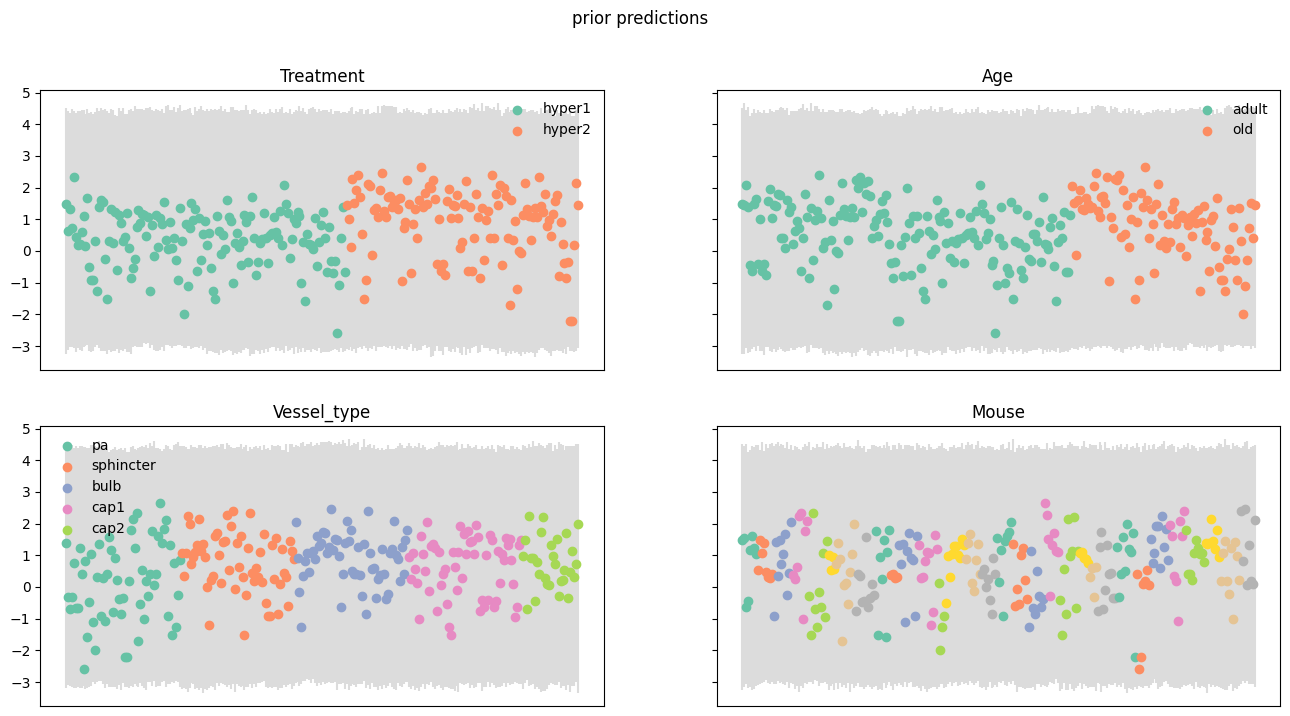

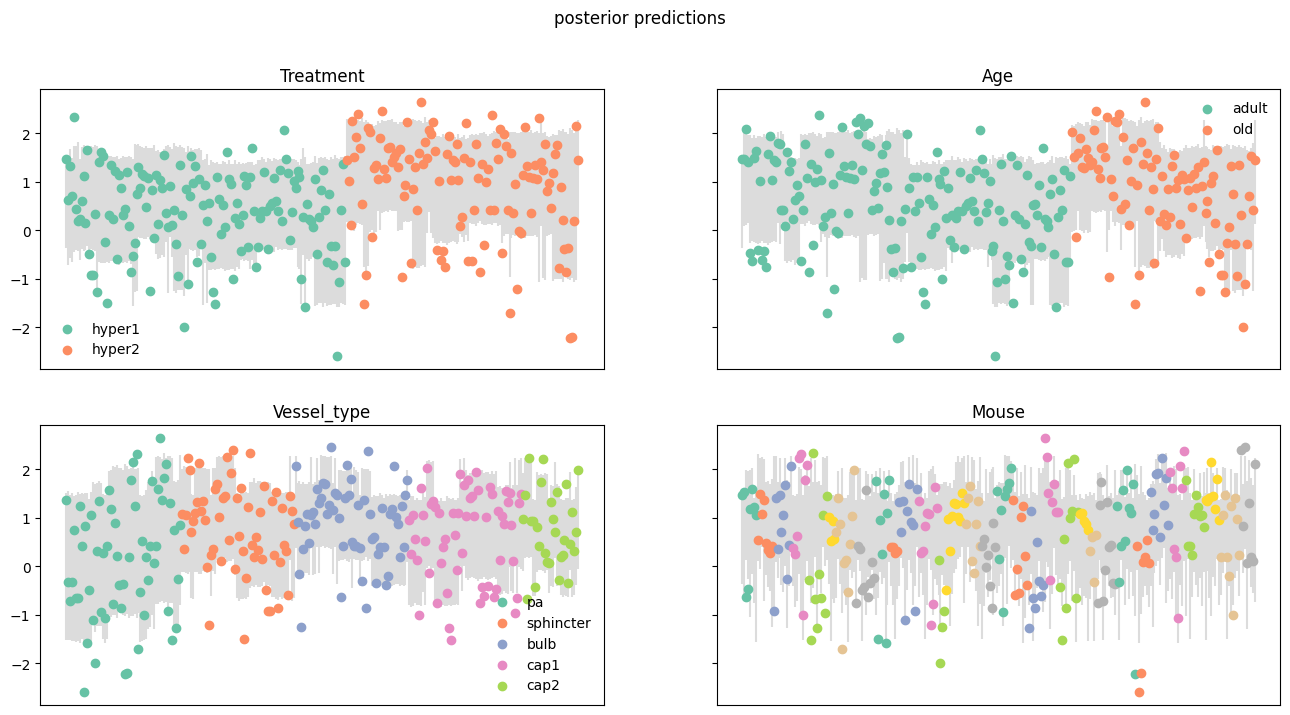

In [9]:
ycol = "atanh_corr_bp_diam"

for group, mode in zip(
    [idata.prior_predictive, idata.posterior_predictive], ["prior", "posterior"]
):
    yrep = group["yrep"]
    obs = msts[ycol]
    f, axes = plt.subplots(2, 2, figsize=[16, 8], sharey=True)
    axes = axes.ravel()
    for ax, col in zip(axes, ["treatment", "age", "vessel_type", "mouse"]):
        obs = plot_obs(ax, msts[ycol], cat=msts[col])
        lines = plot_predictive(ax, yrep, cat=msts[col], zorder=-1)
        if col != "mouse":
            ax.legend(frameon=False)
        ax.set_xticks([])
        ax.set(title=col.capitalize())
    f.suptitle(f"{mode} predictions")
    save_figure(f, f"hypertension-{mode}-predictive")